### Autoencoder Implementation for Dimensionality Reduction in Financial Time Series (8 ETFs)


- Autoencoders are neural networks designed for unsupervised learning of efficient data representations. They consist of:
    - Encoder: Compresses input into latent space representation
    - Decoder: Reconstructs input from latent space
    - Loss Function: Minimizes reconstruction error

Step 1: Data Preparation

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch

# Load your cleaned financial dataset
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = [  # my chosen feature list
    'returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
            'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits'
]
lookback = 20

# Prepare sequences: shape (samples, lookback, n_assets, n_features)
X_list = []
for i in range(lookback, len(data)):
    cur_date = data.iloc[i]['Date']
    day_slice = data[data['Date'] == cur_date]
    if set(assets) <= set(day_slice['Ticker']):
        sample = []
        valid = True
        for asset in assets:
            asset_slice = data[(data['Ticker'] == asset) & (data['Date'] <= cur_date)].tail(lookback)
            if len(asset_slice) == lookback:
                sample.append(asset_slice[features].values)  # (lookback, n_features)
            else:
                valid = False
                break
        if valid:
            X_list.append(np.stack(sample, axis=1))  # (lookback, n_assets, n_features)

X = np.array(X_list)  # (samples, lookback, n_assets, n_features)
print(f"Data shape before scaling: {X.shape}")


Data shape before scaling: (18568, 20, 8, 19)


Step 2: Reshape and Standardize for Autoencoder Input:
- Autoencoders expect 2D input: samples × features. We flatten the temporal and asset dimensions:

In [3]:
samples, lb, n_assets, n_features = X.shape
X_flat = X.reshape(-1, n_features)  # (N, p)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


Step 3: the Autoencoder Neural Network

In [4]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=6):
        super().__init__()
        # Encoder: compress input to latent space
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder: reconstruct input from latent space
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

autoencoder = Autoencoder(input_dim=n_features, latent_dim=7)


Step 4: Train the Autoencoder

In [5]:
import torch.optim as optim

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train(model, data, epochs=100, batch_size=256):
    model.train()
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            recon, _ = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        losses.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
    return losses

loss_history = train(autoencoder, X_tensor, epochs=50)


Epoch 10/50, Loss: 0.008416
Epoch 20/50, Loss: 0.007366
Epoch 30/50, Loss: 0.006886
Epoch 40/50, Loss: 0.006610
Epoch 50/50, Loss: 0.006426


Step 5: Visualizing Training Loss

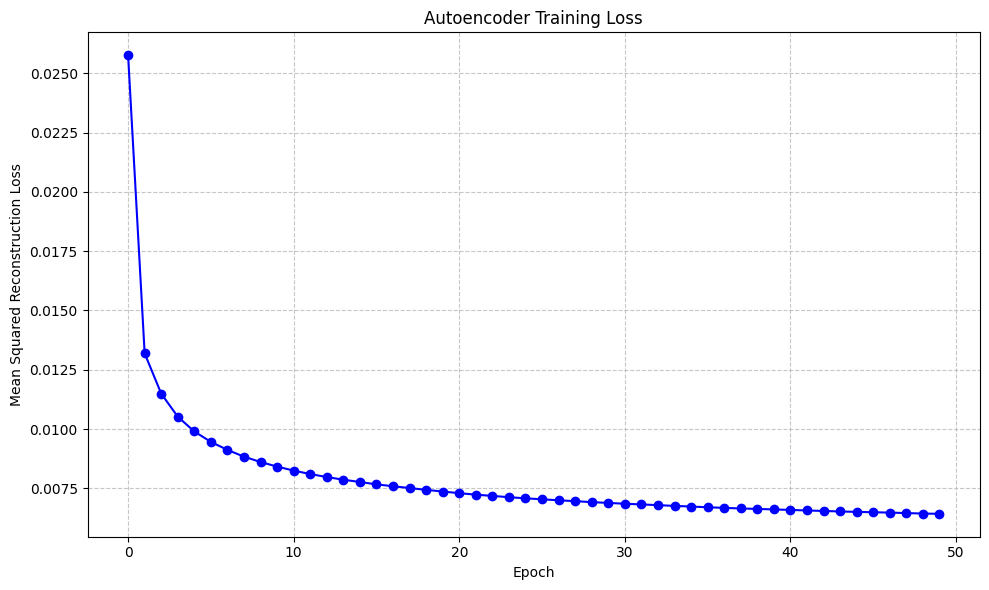

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history, marker='o', color='blue')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Reconstruction Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


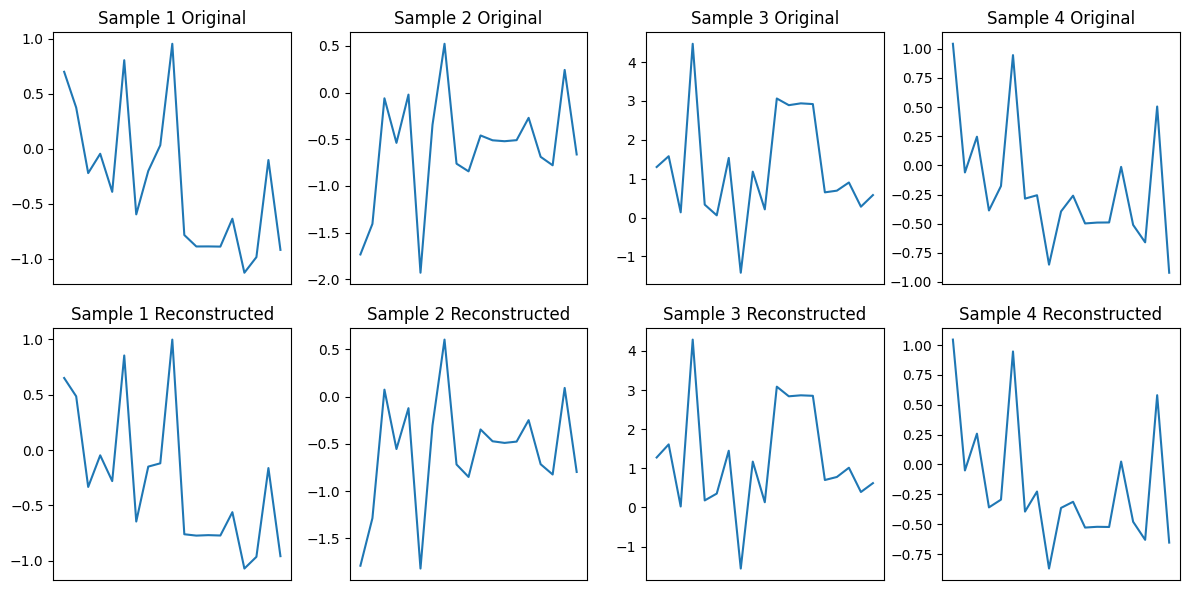

In [9]:
def plot_reconstructions(model, data, n_samples=4):
    model.eval()
    with torch.no_grad():
        indices = np.random.choice(len(data), n_samples)
        originals = data[indices]
        reconstructions, _ = model(originals)
        
        plt.figure(figsize=(12, 6))
        for i in range(n_samples):
            plt.subplot(2, n_samples, i + 1)
            plt.plot(originals[i].numpy(), label='Original')
            plt.title(f'Sample {i+1} Original')
            plt.xticks([])
            plt.subplot(2, n_samples, i + 1 + n_samples)
            plt.plot(reconstructions[i].numpy(), label='Reconstructed')
            plt.title(f'Sample {i+1} Reconstructed')
            plt.xticks([])
        plt.tight_layout()
        plt.show()

plot_reconstructions(autoencoder, X_tensor)



In [10]:
autoencoder.eval()
with torch.no_grad():
    _, latent = autoencoder(X_tensor)
latent_np = latent.numpy()

# Reshape latent vectors back to (samples, lookback, n_assets, latent_dim)
latent_reshaped = latent_np.reshape(samples, lb, n_assets, -1)
print(f"Latent space shape: {latent_reshaped.shape}")


Latent space shape: (18568, 20, 8, 7)


In [11]:
import pandas as pd

# Create column names
latent_dim = latent_np.shape[1]
latent_cols = [f'Latent_{i+1}' for i in range(latent_dim)]

# Create DataFrame and save
df_latent = pd.DataFrame(latent_np, columns=latent_cols)
df_latent.to_csv('autoencoder_latent.csv', index=False)
print("Saved latent representations to 'autoencoder_latent.csv'")


Saved latent representations to 'autoencoder_latent.csv'


/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_94549/3986597297.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_np[:, 0], latent_np[:, 1], alpha=0.5, cmap='viridis')


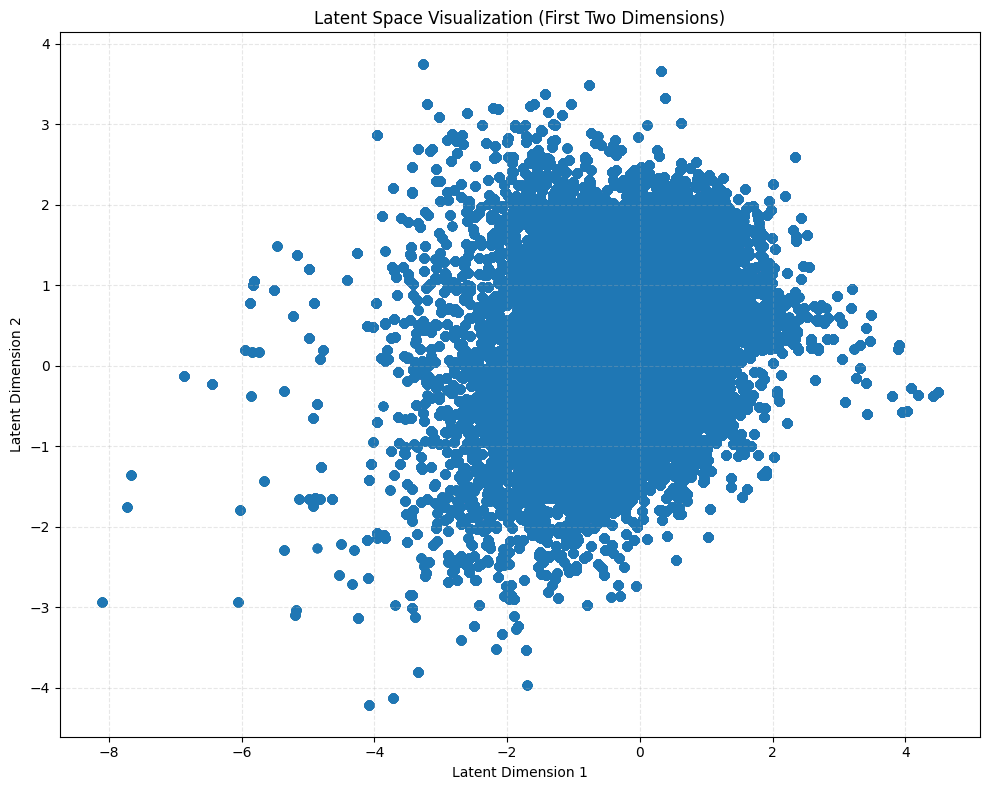

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(latent_np[:, 0], latent_np[:, 1], alpha=0.5, cmap='viridis')
plt.title('Latent Space Visualization (First Two Dimensions)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_np)

plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], alpha=0.5, cmap='viridis')
plt.title('t-SNE Visualization of Autoencoder Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
